In [1]:
import lmfit as lm
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from edo_model_yang import C0, A0, R_m
from lmfit import Parameters, Minimizer
from edo_model_yang import system_odes, solve_model, solve_fit, plot_fit
from get_data import get_weather_data, get_dengue_data, plot_data, get_temp
from parameters import d, theta_m, mu_a, mu_m, gamma_m, C_yang, sup_cap_sin, sup_cap_yang

In [2]:
def briere(T, a, b, c):
    
    return a*T*(T-b)*((c-T)**(1/2))

def b(a, T):
    
    values = []
    for temp in T:
        if (temp > 34) | (temp < 18):
            v = 0
        else: 
            v = briere(temp, a = a, b=18, c = 34)
            
        values.append(v)
    
    return values


def b_(a, T):
    
    dias = np.arange(0, len(T))
  
    f = interpolate.interp1d(dias, b(a, T))
    
    return f 


def beta(a, T):
    
    values = []
    for temp in T:
        if (temp > 34) | (temp < 18):
            v = 0
        else: 
            v = briere(temp, a = a, b=18, c = 34)
            
        values.append(v)
    
    return values

def beta_(a, T):
    
    dias = np.arange(0, len(T))
  
    f = interpolate.interp1d(dias, beta(a, T))
    
    return f 

In [3]:
# parâmetros que serão fixados: 
# parâmetros fixos 
MU_H = 1/(365*67)    #human mortality rate - day^-1
ALPHA_H = 0.1 #recovering rate - day^-1
THETA_H = 0.027   #intrinsic incubation rate - day^-1
K = 0.5          #fraction of female mosquitoes hatched from all egs
C_A = 0.0      #control effort rate on aquatic phase
C_M = 0.0    #control effort rate on terretrial phase

# população de Foz (censo 2010)
N = 256088

par_fixed = MU_H, THETA_H, ALPHA_H, K, C_A, C_M

In [4]:
df = get_dengue_data()
df.head()

,notified,probable,lab_confirmed,acum_notified
date,,,,
2010-01-07,1.571429,0.857143,0.285714,1.571429
2010-01-08,1.857143,1.000000,0.142857,3.428571
2010-01-09,1.857143,1.000000,0.142857,5.285714
2010-01-10,2.000000,1.142857,0.142857,7.285714
2010-01-11,1.714286,0.857143,0.142857,9.000000


Definindo as condições iniciais:

In [5]:
Ms_0 = N

# para T = 28
k = 0.5
delta__ = 8.39
gamma_m__ = 0.12
mu_a__ = 0.06848
mu_m__ = 0.03039
c_m__ = 0.0

A_0 = A0(Ms_0, gamma_m__, mu_m__, c_m__)

C_0 = C0(Ms_0,k,delta__,gamma_m__, mu_m__,mu_a__, c_m = 0, c_a = 0)

Hi0 = 15
Mi0 = 0

print("A0:", A_0)
print("C0:", C_0)

A0: 64854.28600000001
C0: 65600.71992125978


In [6]:
df_ = df.loc[(df.index >= '2010-01-08')  &  (df.index <= '2011-12-31')]

data = df_.acum_notified

T = np.round_(get_temp(start_date = '2010-01-08', end_date = '2011-12-31'), decimals = 1)

df_we = get_weather_data()

df_we = df_we.loc[(df_we.index >= '2010-01-01') & (df_we.index <= '2011-12-31')]

dias = np.arange(0, len(data), 1)

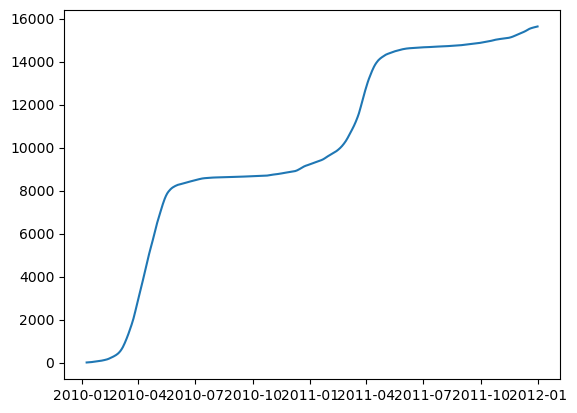

In [7]:
plt.plot(data)

In [8]:
def solve_fit(pars, t, par_fixed, T, df_we, A0, Mi0, Hi0, N = 256088): 
    
    phi = 1
  
    b = b_(pars['a_b'], T)
    
    beta = beta_(pars['a_beta'], T)
  
    par_fit = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)
    
    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = C_yang(df_we, k=7,w1=0.5, C0 = pars['C0'], C1 = 30, C2 = pars['C2'])
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    # definição das condições iniciais
    Ms0 = N
    
    Me0 = 0
    
    Hs0 = phi*N
    
    He0 = 0
    
    Hr0 = (1-phi)*N
    
    y0 = [A0, Ms0, Me0, Mi0, Hs0, He0, Hi0, Hr0]
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    r_fit = solve_model(t, y0, par_fit, param_ento, par_fixed)

    return r_fit

In [9]:
pars = {'a_b':     0.00114744, 
        'a_beta':  0.00128806,
        'C0':      5.33569673,
        'C2':      0.24910195 }


In [10]:
%%time
sol = solve_fit(pars, dias, par_fixed, T, df_we, A_0, Mi0 = 0, Hi0 = 15, N = 256088)


CPU times: user 4.58 s, sys: 10.6 ms, total: 4.59 s
Wall time: 4.59 s


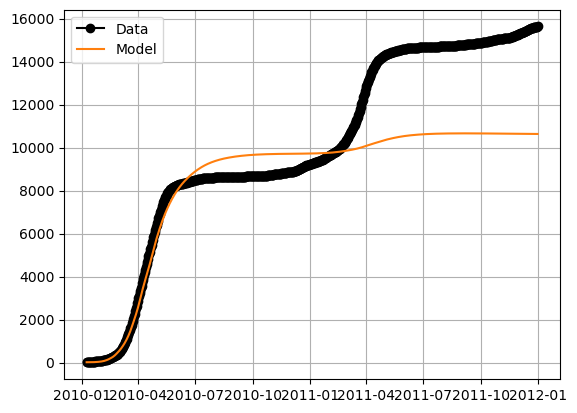

In [11]:
plt.figure()

plt.plot(data, label = 'Data', marker = 'o', color = 'black')

plt.plot(data.index, sol.y[6] + sol.y[7], label = 'Model', color = 'tab:orange')

plt.grid()

plt.legend()

plt.show()

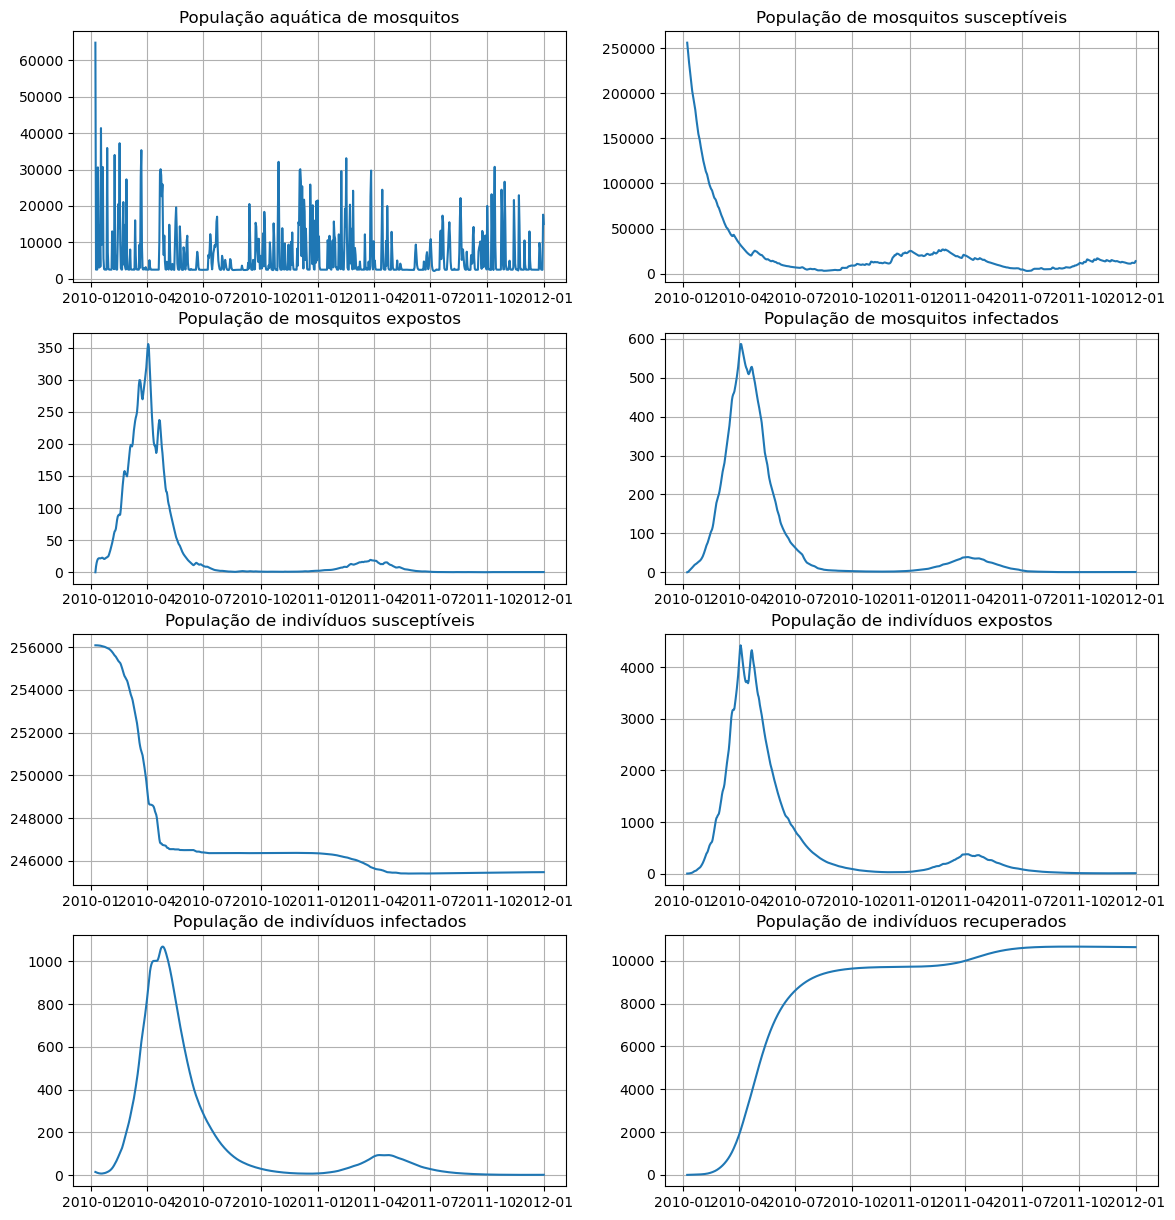

In [26]:
fig, ax = plt.subplots(4,2, figsize = (14,15) )
                       
ax[0,0].plot(data.index, sol.y[0])
                       
ax[0,0].grid()
                       
ax[0,0].set_title('População aquática de mosquitos')       

ax[0,1].plot(data.index, sol.y[1])
                       
ax[0,1].grid()
                       
ax[0,1].set_title('População de mosquitos susceptíveis')       

ax[1,0].plot(data.index, sol.y[2])
                       
ax[1,0].grid()
                       
ax[1,0].set_title('População de mosquitos expostos')       

ax[1,1].plot(data.index, sol.y[3])
                       
ax[1,1].grid()
                       
ax[1,1].set_title('População de mosquitos infectados')    


ax[2,0].plot(data.index, sol.y[4])
                       
ax[2,0].grid()
                       
ax[2,0].set_title('População de indivíduos susceptíveis')       

ax[2,1].plot(data.index, sol.y[5])
                       
ax[2,1].grid()
                       
ax[2,1].set_title('População de indivíduos expostos')       

ax[3,0].plot(data.index, sol.y[6])
                       
ax[3,0].grid()
                       
ax[3,0].set_title('População de indivíduos infectados')       

ax[3,1].plot(data.index, sol.y[7])
                       
ax[3,1].grid()
                       
ax[3,1].set_title('População de indivíduos recuperados')   


plt.show()

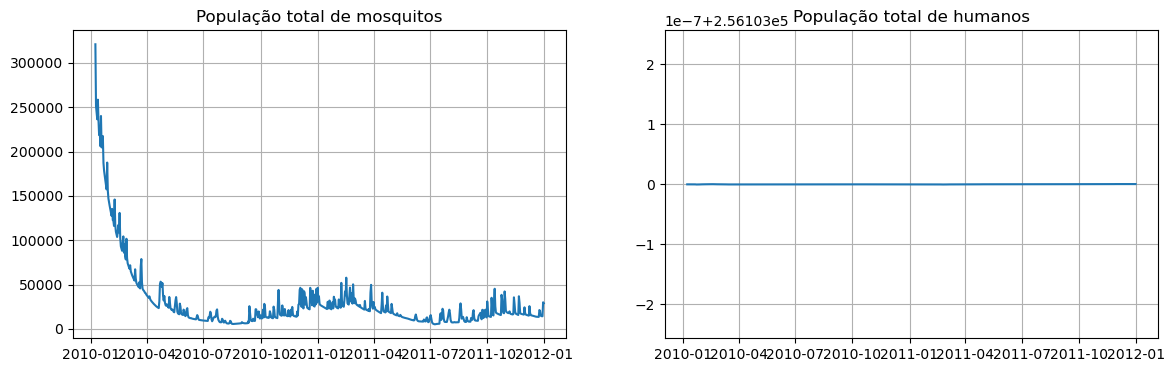

In [33]:
fig, ax = plt.subplots(1,2, figsize = (14,4))

ax[0].plot(data.index, sol.y[0] + sol.y[1] + sol.y[2] + sol.y[3])

ax[0].set_title('População total de mosquitos')

ax[0].grid()

ax[1].plot(data.index, sol.y[4] + sol.y[5] + sol.y[6] + sol.y[7])

ax[1].set_title('População total de humanos')

ax[1].grid()


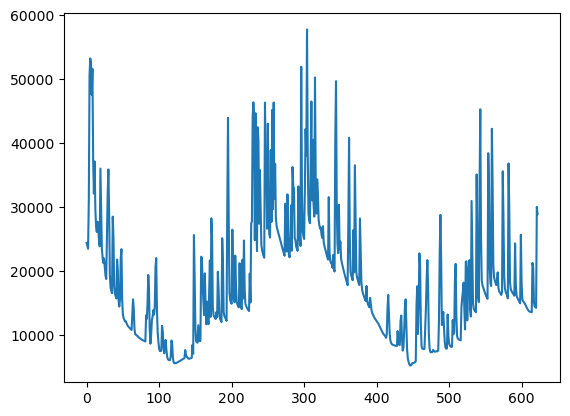

In [35]:
plt.plot((sol.y[0] + sol.y[1] + sol.y[2] + sol.y[3])[100:])